In [147]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import glob

import matplotlib.pyplot as plt
import seaborn as sns
import cv2
#sns.set_style("whitegrid", {"grid.color": ".2", "grid.linestyle": ":"})
sns.set(rc={'axes.labelsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12, 'axes.titlesize':15})

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.optimizers import adam_v2
from keras.layers import Dropout

In [148]:
train_dir = pathlib.Path("../input/blood-cells/dataset2-master/dataset2-master/images/TRAIN")
test_dir = pathlib.Path("../input/blood-cells/dataset2-master/dataset2-master/images/TEST")
test_simple_dir = pathlib.Path("../input/blood-cells/dataset2-master/dataset2-master/images/TEST_SIMPLE")

df = pd.read_csv("../input/blood-cells/dataset2-master/dataset2-master/labels.csv")

In [149]:
class_names = os.listdir(train_dir)
class_names

['MONOCYTE', 'NEUTROPHIL', 'LYMPHOCYTE', 'EOSINOPHIL']

## Basic Exploration and Manual Identificaion

In [150]:
# train and test size
image_count_train = len(list(train_dir.glob('*/*.jpeg')))
print(image_count_train)
image_count_test = len(list(test_dir.glob('*/*.jpeg')))
print(image_count_test)
image_count_test_simple = len(list(test_simple_dir.glob('*/*.jpeg')))
print(image_count_test_simple)

9957
2487
71


Visualizing some sample images.

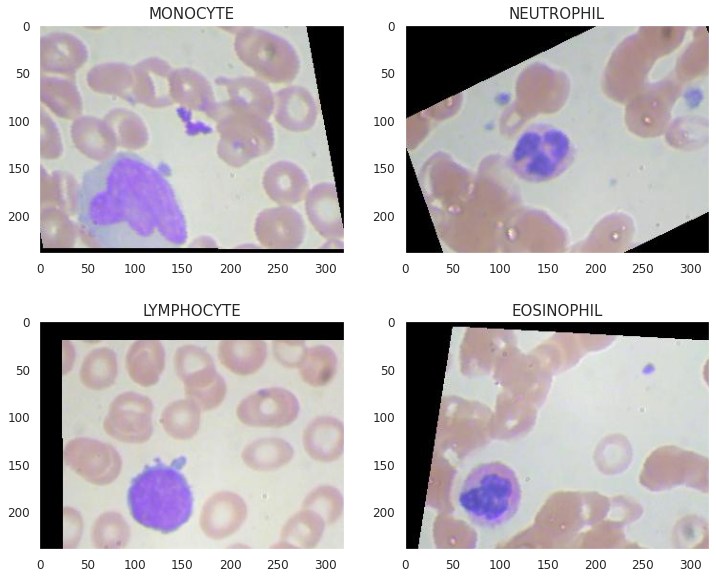

In [151]:
# Plot Image
def plotImage(image_path):
    image = cv2.imread(image_path)  # BGR
    image = image[:, :, [2, 1, 0]]  # Reorder to RGB for Matplotlib display
    plt.imshow(image)
    return

plt.figure(figsize=(12,10))
for i in range(4): 
    plt.subplot(2, 2, i + 1)
    plotImage(str(list(train_dir.glob(class_names[i]+'/*.jpeg'))[0]))
    plt.title(class_names[i])
    plt.grid()

Summary of Training and Test composition.

In [152]:
print('Training samples:')
num_samples = 0
for cell in os.listdir(train_dir):
    num_cells = len(os.listdir(os.path.join(train_dir, cell)))
    num_samples += num_cells
    print('Cell: {:15s}  num samples: {:d}'.format(cell, num_cells))
print('Total training samples: {:d}\n'.format(num_samples))

print('Test samples:')
num_samples = 0
for cell in os.listdir(test_dir):
    num_cells = len(os.listdir(os.path.join(test_dir, cell)))
    num_samples += num_cells
    print('Cell: {:15s}  num samples: {:d}'.format(cell, num_cells))
print('Total test samples: {:d}'.format(num_samples))

Training samples:
Cell: MONOCYTE         num samples: 2478
Cell: NEUTROPHIL       num samples: 2499
Cell: LYMPHOCYTE       num samples: 2483
Cell: EOSINOPHIL       num samples: 2497
Total training samples: 9957

Test samples:
Cell: MONOCYTE         num samples: 620
Cell: NEUTROPHIL       num samples: 624
Cell: LYMPHOCYTE       num samples: 620
Cell: EOSINOPHIL       num samples: 623
Total test samples: 2487


#### Plotting function for Learning Curve

In [153]:
# function to plot the training/validation accuracies/losses.

def plot_learning(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    #axes[0].grid()
    axes[0].legend(['loss','val_loss'])
    axes[1].plot(history.history['accuracy'])   
    axes[1].plot(history.history['val_accuracy'])
    #axes[1].grid()
    axes[1].legend(['accuracy','val_accuracy'])

## Training a Simple Model

In [154]:
# resolution of images
plt.imread(str(list(train_dir.glob(class_names[i]+'/*.jpeg'))[0])).shape

(240, 320, 3)

In [155]:
# defining some parameters for the loader

batch_size = 32
img_height = 120
img_width = 120

# lower resolution images reduce the definition/clarity of certain features in images.
# It can make it harder for CNN to learn the features required for classification or detection.
# working with 120 x 120 resolution images for now.

In [375]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=21,
    validation_split= 0.12,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 9957 files belonging to 4 classes.
Using 8763 files for training.


In [376]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=21,
    validation_split= 0.12,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 9957 files belonging to 4 classes.
Using 1194 files for validation.


In [377]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2487 files belonging to 4 classes.


#### Model 1

In [ ]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 4

model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (120, 120, 3)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

In [ ]:
model.summary()

In [ ]:
tf.test.is_gpu_available()
#tf.test.gpu_device_name()

In [ ]:
optimizer = adam_v2.Adam()   #"adam" #'RMSprop'
#loss = tf.keras.losses.CategoricalCrossentropy()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])

epochs = 20
history_model = model.fit(
                    train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    #callbacks=callbacks
)

In [ ]:
plot_learning(history_model)

> The model successfully overfitted

#### Model 2

In [ ]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.regularizers import l2
num_classes = 4

model = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))])

model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (120, 120, 32)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.20))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.20))


model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(128, activation='relu'))
#model.add(Dense(128, kernel_regularizer = l2(0.001), activation='relu'))

model.add(Dense(num_classes, activation = "softmax"))

In [ ]:
#callbacks
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                            min_delta=0.00001, patience=10, mode='auto', verbose=0, restore_best_weights=True)

lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1, min_lr=0.00001, patience=5)

callbacks = [lr_reducer]

In [ ]:
model.summary()

In [ ]:
optimizer = adam_v2.Adam()   #"adam" #'RMSprop'
#loss = tf.keras.losses.CategoricalCrossentropy()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])

epochs = 50
history_model = model.fit(
                    train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    callbacks=callbacks
)

In [ ]:
plot_learning(history_model)

> Model performs really well but has a slight overfitting problem.

In [ ]:
# Evaluating performance on test set

results = model.evaluate(test_ds)

print("Loss of the model  is - test ", results[0])
print("Accuracy of the model is - test", results[1]*100, "%\n")


results = model.evaluate(val_ds)

print("Loss of the model  is - val ", results[0])
print("Accuracy of the model is - val", results[1]*100, "%\n")

results = model.evaluate(train_ds)

print("Loss of the model  is - train ", results[0])
print("Accuracy of the model is - train", results[1]*100, "%")

#### Model 3

In [ ]:
# defining some parameters for the loader

batch_size = 64
img_height = 160
img_width = 160

# working with 160 x 160 resolution images.

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=21,
    validation_split= 0.12,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=21,
    validation_split= 0.12,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(img_height,img_width),
    batch_size = batch_size
)

In [ ]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.regularizers import l2
num_classes = 4

model = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))])

model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (160, 160, 32)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))


model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(128, activation='relu'))
#model.add(Dense(128, kernel_regularizer = l2(0.001), activation='relu'))

model.add(Dense(num_classes, activation = "softmax"))

In [ ]:
model.summary()

In [ ]:
optimizer = adam_v2.Adam(lr=0.0002)   #"adam" #'RMSprop'
#loss = tf.keras.losses.CategoricalCrossentropy()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])

epochs = 50
history_model = model.fit(
                    train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    callbacks=callbacks
)

In [ ]:
plot_learning(history_model)

> Model give phenomenal result on training data but has slightly overfitted.**

In [ ]:
# Evaluating performance on test set

results = model.evaluate(test_ds)

print("Loss of the model  is - test ", results[0])
print("Accuracy of the model is - test", results[1]*100, "%\n")


results = model.evaluate(val_ds)

print("Loss of the model  is - val ", results[0])
print("Accuracy of the model is - val", results[1]*100, "%\n")

results = model.evaluate(train_ds)

print("Loss of the model  is - train ", results[0])
print("Accuracy of the model is - train", results[1]*100, "%")

In [ ]:
from sklearn.metrics import classification_report

predictions = np.array([])
labels =  np.array([])
for x, y in test_ds:
    y_pred = np.argmax(model.predict(x, verbose=0),axis=1)
    predictions = np.concatenate([predictions, y_pred])
    labels = np.concatenate([labels, y.numpy()])

In [ ]:
print(classification_report(labels,predictions,
                           target_names = ['EOSINOPHIL (Class 0)', 'LYMPHOCYTE (Class 1)', 'MONOCYTE (Class 2)', 'NEUTROPHIL (Class 3)']))

In [ ]:
for images, labels in test_ds.take(2):
    plt.imshow(images[0].numpy().astype("uint8"))
    print(images.shape)
    print(labels.shape)

## Data Augmentation, Custom Data Generator

In [159]:
os.path.join(train_dir,'MONOCYTE','sadasd')
train_ds.class_names

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

In [205]:
from tqdm import tqdm
def load_data(mode = 'train'):
    
    #datasets = ['/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN','/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TEST']
    images = []
    labels = []

    # iterate through training and test sets
    count =0
    
    if mode == 'train':
        dataset = "/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN"
    else:
        dataset = "/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TEST"

    # iterate through folders in each dataset
    for folder in os.listdir(dataset):

        if folder in ['EOSINOPHIL']: label = 0
        elif folder in ['LYMPHOCYTE']: label = 1
        elif folder in ['MONOCYTE']: label = 2
        elif folder in ['NEUTROPHIL']: label = 3

        # iterate through each image in folder
        for file in tqdm(os.listdir(os.path.join(dataset, folder))):

            # get pathname of each image
            img_path = os.path.join(os.path.join(dataset, folder), file)

            # Open 
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # resize the image
            #image = cv2.resize(image, image_size)
            image = preprocess_img(image, (img_height,img_width,3), mode = 'test')
            
            # Append the image and its corresponding label to the output
            images.append(image)
            labels.append(label)

    images = np.array(images, dtype = 'float32')
    labels = np.array(labels, dtype = 'int32')

    return images, labels

In [161]:
train_df = pd.DataFrame(columns=['path','cell_class'])
img_path = np.array([])
labels =  np.array([])
for cell_class in os.listdir(train_dir):
    print(os.path.join(train_dir, cell_class))
    print(len(os.listdir(os.path.join(train_dir,cell_class))))
    img_path = np.concatenate([img_path, [os.path.join(train_dir,cell_class,k) for k in os.listdir(os.path.join(train_dir,cell_class))]])
    labels = np.concatenate([labels, np.array([cell_class]*len(os.listdir(os.path.join(train_dir,cell_class))))])
train_df['path'] = img_path
train_df['cell_class'] = labels

../input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/MONOCYTE
2478
../input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/NEUTROPHIL
2499
../input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE
2483
../input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/EOSINOPHIL
2497


In [357]:
# defining some parameters for the loader

batch_size = 64
img_height = 120
img_width = 160

# working with 120 x 160 resolution images. Keeping the aspect ratio same this time.

In [359]:
#function for preprocessing the images
from skimage import io
from skimage.transform import rescale, resize

datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    #featurewise_center=True,
    #featurewise_std_normalization=True,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range = 0.2,
    horizontal_flip=True,
    vertical_flip=True,)

def preprocess_img(img, output_shape, mode):
    #img = (img - img.min())/(img.max() - img.min())
    #img = rescale(img, 0.25, multichannel=True, mode='constant')
    img = resize(img, output_shape, anti_aliasing=True, mode='constant')
    
    if mode == 'train':
        if np.random.randn() > 0:
            img = datagen.random_transform(img)
    return img

In [360]:
SEED = 12345
DATASET_PATH = train_dir
class_names = train_ds.class_names

class AugmentedDataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, mode='train', class_names = class_names, 
                 batch_size=batch_size, dim=(img_height, img_width), n_channels=3, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = {}
        self.list_IDs = []
        self.mode = mode
        
        for i, ccls in enumerate(class_names):
            paths = glob.glob(os.path.join(DATASET_PATH, ccls, '*'))
            brk_point = int(len(paths)*0.85)
            if self.mode == 'train':
                #paths = paths[:brk_point]
                paths_series = pd.Series(paths)
                paths = paths_series.sample(frac = 0.85, random_state=SEED).to_list()
            else:
                #paths = paths[brk_point:]
                paths_series = pd.Series(paths)
                paths_1 = paths_series.sample(frac = 0.85, random_state=SEED)
                paths = [p for p in paths_series.to_list() if p not in paths_1]
            self.list_IDs += paths
            self.labels.update({p:i for p in paths})
        
            
        self.n_channels = n_channels
        self.n_classes = len(class_names)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'

        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        
        delete_rows = []

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            img = io.imread(ID)
            #img = img[:, :, np.newaxis]
            #if img.shape == (240, 320, 3):
            img = preprocess_img(img, output_shape=(img_height, img_width, self.n_channels), mode=self.mode)
            X[i,] = img
            y[i] = self.labels[ID]
            #else:
            #    delete_rows.append(i)
            #    continue
        
        X = np.delete(X, delete_rows, axis=0)
        y = np.delete(y, delete_rows, axis=0)
        
        return X, y#tf.keras.utils.to_categorical(y, num_classes=self.n_classes)

In [167]:
train_gen = AugmentedDataGenerator('train')
val_gen = AugmentedDataGenerator('val')

In [361]:
#callbacks
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                            min_delta=0.00001, patience=8, mode='auto', verbose=0, restore_best_weights=True)

lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1, min_lr=0.00001, patience=5)

callbacks = [early_stopping_callback, lr_reducer]

#### Model 4

In [45]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.regularizers import l2
num_classes = 4

model = Sequential([layers.experimental.preprocessing.Rescaling(1./1., input_shape=(img_height, img_width,3))])

model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (120, 160, 32)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))


model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(128, activation='relu'))
#model.add(Dense(128, kernel_regularizer = l2(0.001), activation='relu'))

model.add(Dense(num_classes, activation = "softmax"))

In [46]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 120, 160, 3)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 120, 160, 32)      896       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 60, 80, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 60, 80, 32)        9248      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 30, 40, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 30, 40, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 15, 20, 64)       

In [47]:
optimizer = adam_v2.Adam(learning_rate=0.0002)   #"adam" #'RMSprop'
#loss = tf.keras.losses.CategoricalCrossentropy()
loss = tf.keras.losses.SparseCategoricalCrossentropy()  #(from_logits=True)
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])

epochs = 50
history_model = model.fit(
                    train_gen,
                    validation_data=val_gen,
                    epochs=epochs,
                    callbacks=callbacks
)

Epoch 1/50
132/132 [==============================] - 127s 958ms/step - loss: 1.3870 - accuracy: 0.2528 - val_loss: 1.3864 - val_accuracy: 0.2520
Epoch 2/50
132/132 [==============================] - 126s 954ms/step - loss: 1.3866 - accuracy: 0.2474 - val_loss: 1.3863 - val_accuracy: 0.2493
Epoch 3/50
132/132 [==============================] - 126s 954ms/step - loss: 1.3864 - accuracy: 0.2431 - val_loss: 1.3863 - val_accuracy: 0.2473
Epoch 4/50
132/132 [==============================] - 126s 953ms/step - loss: 1.3647 - accuracy: 0.2827 - val_loss: 1.2786 - val_accuracy: 0.3940
Epoch 5/50
132/132 [==============================] - 125s 947ms/step - loss: 1.2037 - accuracy: 0.3887 - val_loss: 1.0582 - val_accuracy: 0.4674
Epoch 6/50
132/132 [==============================] - 126s 953ms/step - loss: 1.0347 - accuracy: 0.4962 - val_loss: 0.9857 - val_accuracy: 0.5822
Epoch 7/50
132/132 [==============================] - 129s 977ms/step - loss: 0.8390 - accuracy: 0.6291 - val_loss: 0.6114 -

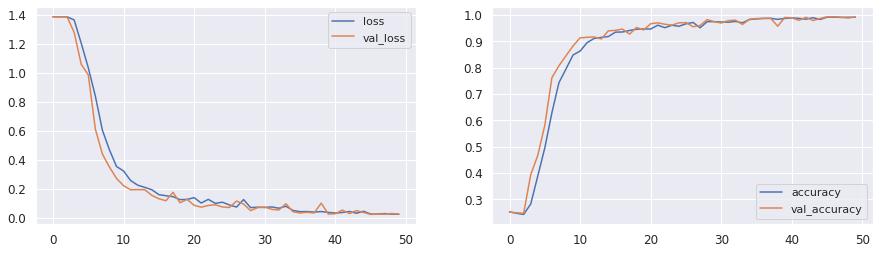

In [48]:
plot_learning(history_model)

In [24]:
#save model
#!mkdir -p saved_model
#model.save('saved_model/best_model0.h5')

#load_model
model = tf.keras.models.load_model('./saved_model/best_model0.h5')

In [206]:
#loading data again
X_train, y_train = load_data(mode = 'train')
X_test, y_test = load_data(mode = 'test')

100%|██████████| 623/623 [00:10<00:00, 57.62it/s]


In [28]:
# Evaluating performance on test set

results = model.evaluate(X_test, y_test)

print("Loss of the model  is - test ", results[0])
print("Accuracy of the model is - test", results[1]*100, "%\n")

results = model.evaluate(X_train, y_train)

print("Loss of the model  is - train ", results[0])
print("Accuracy of the model is - train", results[1]*100, "%")

78/78 [==============================] - 1s 9ms/step - loss: 0.5929 - accuracy: 0.8697
Loss of the model  is - test  0.5929418206214905
Accuracy of the model is - test 86.97225451469421 %



2022-10-19 07:08:21.123915: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2294092800 exceeds 10% of free system memory.
2022-10-19 07:08:23.831562: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2294092800 exceeds 10% of free system memory.


312/312 [==============================] - 2s 6ms/step - loss: 0.0067 - accuracy: 0.9992
Loss of the model  is - train  0.006697879172861576
Accuracy of the model is - train 99.91965293884277 %


In [34]:
from sklearn.metrics import classification_report

labels = y_test
predictions = np.argmax(model.predict(X_test, verbose=1),axis=1)

print(classification_report(labels,predictions,
                           target_names = ['EOSINOPHIL (Class 0)', 'LYMPHOCYTE (Class 1)', 'MONOCYTE (Class 2)', 'NEUTROPHIL (Class 3)']))

78/78 [==============================] - 0s 5ms/step
                      precision    recall  f1-score   support

EOSINOPHIL (Class 0)       0.96      0.77      0.85       623
LYMPHOCYTE (Class 1)       1.00      1.00      1.00       620
  MONOCYTE (Class 2)       0.97      0.76      0.85       620
NEUTROPHIL (Class 3)       0.67      0.95      0.79       624

            accuracy                           0.87      2487
           macro avg       0.90      0.87      0.87      2487
        weighted avg       0.90      0.87      0.87      2487



#### Model 5

Using Transfer Learning this time around to compare the reusults.

In [363]:
# defining some parameters for the loader

batch_size = 64
img_height = 160
img_width = 160

# working with 160 x 160 resolution images.

In [197]:
train_gen = AugmentedDataGenerator('train')
val_gen = AugmentedDataGenerator('val')

In [364]:
# importing the MobileNet model due to it's lightweight architecture and high speed performance as compared 
# to other heavy-duty models like VGG16, Alexnet, InceptionV3 etc.

#from keras.applications import mobilenet
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [403]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(img_height, img_width, 3),
                                               include_top=False,
                                               weights='imagenet')

In [175]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_8[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [397]:
#last two layers
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

Conv_1_bn
out_relu


In [407]:
#callbacks
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                            min_delta=0.00001, patience=8, mode='auto', verbose=0, restore_best_weights=True)

lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1, min_lr=0.00001, patience=4)

callbacks = [early_stopping_callback, lr_reducer]

In [200]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
num_classes = 4

model = Sequential([layers.experimental.preprocessing.Rescaling(1./1., input_shape=(img_height, img_width,3))])
base_model.trainable=False
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.20))
#model.add(Flatten())
#model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.25))
#model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.20))
model.add(Dense(128, activation='relu'))
#model.add(Dense(128, kernel_regularizer = l2(0.001), activation='relu'))

model.add(Dense(num_classes, activation = "softmax"))

In [201]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_16 (Rescaling)     (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_14  (None, 1280)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 128)               163968    
_________________________________________________________________
dense_33 (Dense)             (None, 4)                 516       
Total params: 2,422,468
Trainable params: 164,484
Non-trainable params: 2,257,984
_____________________________________

In [202]:
optimizer = adam_v2.Adam(learning_rate=0.0002)   #"adam" #'RMSprop'
#loss = tf.keras.losses.CategoricalCrossentropy()
loss = tf.keras.losses.SparseCategoricalCrossentropy()  #(from_logits=True)
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])

epochs = 50
history_model = model.fit(
                    train_gen,
                    validation_data=val_gen,
                    epochs=epochs,
                    callbacks=callbacks
)

Epoch 1/50
132/132 [==============================] - 258s 2s/step - loss: 1.1990 - accuracy: 0.4703 - val_loss: 0.9178 - val_accuracy: 0.6335
Epoch 2/50
132/132 [==============================] - 252s 2s/step - loss: 0.9407 - accuracy: 0.6113 - val_loss: 0.7694 - val_accuracy: 0.7021
Epoch 3/50
132/132 [==============================] - 249s 2s/step - loss: 0.8371 - accuracy: 0.6558 - val_loss: 0.6754 - val_accuracy: 0.7405
Epoch 4/50
132/132 [==============================] - 248s 2s/step - loss: 0.7683 - accuracy: 0.6869 - val_loss: 0.6131 - val_accuracy: 0.7698
Epoch 5/50
132/132 [==============================] - 249s 2s/step - loss: 0.7272 - accuracy: 0.7009 - val_loss: 0.5838 - val_accuracy: 0.7787
Epoch 6/50
132/132 [==============================] - 248s 2s/step - loss: 0.6999 - accuracy: 0.7172 - val_loss: 0.5386 - val_accuracy: 0.8112
Epoch 7/50
132/132 [==============================] - 250s 2s/step - loss: 0.6660 - accuracy: 0.7302 - val_loss: 0.5101 - val_accuracy: 0.8235

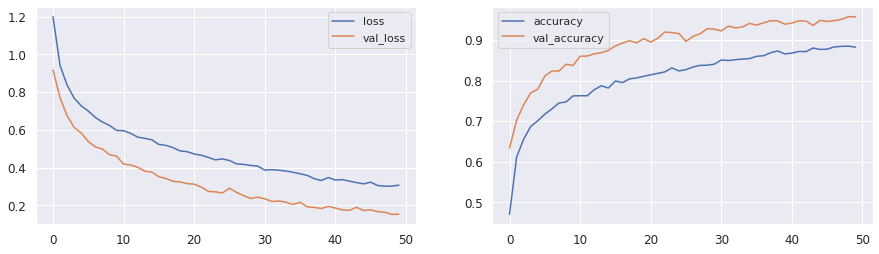

In [362]:
plot_learning(history_model)

In [ ]:
# Evaluating performance on test set

results = model.evaluate(X_test, y_test)

print("Loss of the model  is - test ", results[0])
print("Accuracy of the model is - test", results[1]*100, "%\n")

results = model.evaluate(X_train, y_train)

print("Loss of the model  is - train ", results[0])
print("Accuracy of the model is - train", results[1]*100, "%")

#### Model 6

In [404]:
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split = 0.15,
    #featurewise_center=True,
    #featurewise_std_normalization=True,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range = 0.2,
    horizontal_flip=True,
    vertical_flip=True,)
datagen1 = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(
    train_dir,
    subset="training",
    seed=123,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
)
val_gen = datagen.flow_from_directory(
    train_dir,
    subset="validation",
    seed=123,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
)
test_gen = datagen1.flow_from_directory(    
    directory=test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
)

Found 8466 images belonging to 4 classes.
Found 1491 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [405]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
num_classes = 4

model = Sequential([layers.experimental.preprocessing.Rescaling(1./1., input_shape=(img_height, img_width,3))])
base_model.trainable=False
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.20))
#model.add(Flatten())
#model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.25))
#model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.20))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(128, kernel_regularizer = l2(0.001), activation='relu'))

model.add(Dense(num_classes, activation = "softmax"))

In [406]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_20 (Rescaling)     (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_18  (None, 1280)              0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_40 (Dense)             (None, 128)               163968    
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 128)             

In [408]:
optimizer = adam_v2.Adam(learning_rate=0.0002)   #"adam" #'RMSprop'
loss = tf.keras.losses.CategoricalCrossentropy()
#loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])

epochs = 50
history_model = model.fit(
                    train_gen,
                    validation_data=val_gen,
                    epochs=epochs,
                    callbacks=callbacks
)

Epoch 1/50
133/133 [==============================] - 74s 536ms/step - loss: 1.4487 - accuracy: 0.3736 - val_loss: 1.2810 - val_accuracy: 0.5017
Epoch 2/50
133/133 [==============================] - 70s 529ms/step - loss: 1.2864 - accuracy: 0.4817 - val_loss: 1.1388 - val_accuracy: 0.5788
Epoch 3/50
133/133 [==============================] - 70s 524ms/step - loss: 1.1867 - accuracy: 0.5318 - val_loss: 1.0391 - val_accuracy: 0.5983
Epoch 4/50
133/133 [==============================] - 70s 525ms/step - loss: 1.1186 - accuracy: 0.5757 - val_loss: 0.9960 - val_accuracy: 0.6197
Epoch 5/50
133/133 [==============================] - 71s 531ms/step - loss: 1.0748 - accuracy: 0.5817 - val_loss: 0.9322 - val_accuracy: 0.6613
Epoch 6/50
133/133 [==============================] - 71s 533ms/step - loss: 1.0245 - accuracy: 0.6074 - val_loss: 0.9073 - val_accuracy: 0.6767
Epoch 7/50
133/133 [==============================] - 71s 537ms/step - loss: 1.0058 - accuracy: 0.6194 - val_loss: 0.8736 - val_ac

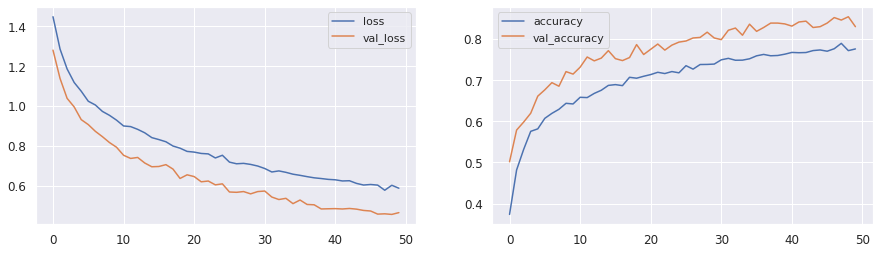

In [409]:
plot_learning(history_model)

In [410]:
# Evaluating performance on test set

results = model.evaluate(test_gen)

print("Loss of the model  is - test ", results[0])
print("Accuracy of the model is - test", results[1]*100, "%\n")


results = model.evaluate(val_gen)

print("Loss of the model  is - val ", results[0])
print("Accuracy of the model is - val", results[1]*100, "%\n")

results = model.evaluate(train_gen)

print("Loss of the model  is - train ", results[0])
print("Accuracy of the model is - train", results[1]*100, "%")

39/39 [==============================] - 8s 194ms/step - loss: 1.3220 - accuracy: 0.5573
Loss of the model  is - test  1.3220458030700684
Accuracy of the model is - test 55.7297945022583 %

24/24 [==============================] - 12s 486ms/step - loss: 0.4491 - accuracy: 0.8524
Loss of the model  is - val  0.44914937019348145
Accuracy of the model is - val 85.2448046207428 %

133/133 [==============================] - 59s 446ms/step - loss: 0.4306 - accuracy: 0.8583
Loss of the model  is - train  0.4305948317050934
Accuracy of the model is - train 85.82565784454346 %
